In [287]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price                              adj close       close        high  \
date                      ticker                                       
2016-08-29 00:00:00+00:00 A        44.720501   47.619999   47.889999   
                          AAL      34.864250   36.169998   36.410000   
                          AAPL     24.632544   26.705000   26.860001   
                          ABBV     45.698761   64.510002   65.089996   
                          ABT      37.360985   43.250000   43.570000   
...                                      ...         ...         ...   
2024-08-28 00:00:00+00:00 XYL     135.820007  135.820007  136.630005   
                          YUM     135.649994  135.649994  136.300003   
                          ZBH     114.190002  114.190002  115.150002   
                          ZBRA    343.829987  343.829987  347.200012   
                          ZTS     182.910004  182.910004  184.610001   

Price                                    low        open      volume  
date                      ticker                                      
2016-08-29 00:00:00+00:00 A        47.310001   47.450001   1333000.0  
                          AAL      36.049999   36.130001   4760700.0  
                          AAPL     26.572500   26.655001  99881200.0  
                          ABBV     64.190002   64.839996   5099200.0  
                          ABT      42.950001   43.000000   9223200.0  
...                                      ...         ...         ...  
2024-08-28 00:00:00+00:00 XYL     135.330002  135.770004    923400.0  
                          YUM     134.360001  134.750000   2180100.0  
                          ZBH     113.860001  114.720001    687000.0  
                          ZBRA    342.000000  344.679993    211200.0  
                          ZTS     182.100006  182.100006   1485400.0  

[991755 rows x 6 columns]

In [288]:
#Calculating Features, 1: Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume


# Garnan-Klass Volatility = (In(High)-In(low))^2/2 -(2 In(2)-1)(In(adj Close)- In(open))^2
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df


Price                              adj close       close        high  \
date                      ticker                                       
2016-08-29 00:00:00+00:00 A        44.720501   47.619999   47.889999   
                          AAL      34.864250   36.169998   36.410000   
                          AAPL     24.632544   26.705000   26.860001   
                          ABBV     45.698761   64.510002   65.089996   
                          ABT      37.360985   43.250000   43.570000   
...                                      ...         ...         ...   
2024-08-28 00:00:00+00:00 XYL     135.820007  135.820007  136.630005   
                          YUM     135.649994  135.649994  136.300003   
                          ZBH     114.190002  114.190002  115.150002   
                          ZBRA    343.829987  343.829987  347.200012   
                          ZTS     182.910004  182.910004  184.610001   

Price                                    low        open      volume  \
date                      ticker                                       
2016-08-29 00:00:00+00:00 A        47.310001   47.450001   1333000.0   
                          AAL      36.049999   36.130001   4760700.0   
                          AAPL     26.572500   26.655001  99881200.0   
                          ABBV     64.190002   64.839996   5099200.0   
                          ABT      42.950001   43.000000   9223200.0   
...                                      ...         ...         ...   
2024-08-28 00:00:00+00:00 XYL     135.330002  135.770004    923400.0   
                          YUM     134.360001  134.750000   2180100.0   
                          ZBH     113.860001  114.720001    687000.0   
                          ZBRA    342.000000  344.679993    211200.0   
                          ZTS     182.100006  182.100006   1485400.0   

Price                             garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2016-08-29 00:00:00+00:00 A              -0.001282        NaN       NaN   
                          AAL            -0.000442        NaN       NaN   
                          AAPL           -0.002347        NaN       NaN   
                          ABBV           -0.047184        NaN       NaN   
                          ABT            -0.007531        NaN       NaN   
...                                            ...        ...       ...   
2024-08-28 00:00:00+00:00 XYL             0.000046  52.535138  4.838300   
                          YUM             0.000086  54.607783  4.899979   
                          ZBH             0.000055  58.030122  4.667332   
                          ZBRA            0.000112  57.387067  5.741514   
                          ZTS             0.000086  53.227214  5.185861   

Price                               bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2016-08-29 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAL          NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-08-28 00:00:00+00:00 XYL     4.890613  4.942926  0.773840  0.038124   
                          YUM     4.917179  4.934379  0.409176  0.490281   
                          ZBH     4.715380  4.763429 -0.779255  0.565145   
                          ZBRA    5.815956  5.890399  0.186636  0.680882   
                          ZTS     5.216292  5.246723  0.449654  0.119597   

Price                             dollar_volume  
date                      ticker                 
2016-08-29 00:00:00+00:00 A           59.612428  
           

In [289]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol  \
date                      ticker                                                
2016-10-31 00:00:00+00:00 A           75.765037   41.018745         -0.001089   
                          AAL        317.077346   39.134327         -0.000176   
                          AAPL      3494.595166   26.182169         -0.002541   
                          ABBV       274.543300   39.878784         -0.049190   
                          ABT        317.927984   34.112480         -0.008074   
...                                         ...         ...               ...   
2024-08-31 00:00:00+00:00 XYL        153.288873  135.820007          0.000046   
                          YUM        259.678573  135.649994          0.000086   
                          ZBH        140.912810  114.190002          0.000055   
                          ZBRA       117.023683  343.829987          0.000112   
                          ZTS        337.139962  182.910004          0.000086   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2016-10-31 00:00:00+00:00 A       35.933736  3.718486  3.778792  3.839099   
                          AAL     62.786061  3.604673  3.655493  3.706314   
                          AAPL    49.022115  3.293123  3.322002  3.350880   
                          ABBV    26.094529  3.744517  3.798670  3.852823   
                          ABT     37.005141  3.549492  3.599959  3.650426   
...                                     ...       ...       ...       ...   
2024-08-31 00:00:00+00:00 XYL     52.535138  4.838300  4.890613  4.942926   
                          YUM     54.607783  4.899979  4.917179  4.934379   
                          ZBH     58.030122  4.667332  4.715380  4.763429   
                          ZBRA    57.387067  5.741514  5.815956  5.890399   
                          ZTS     53.227214  5.185861  5.216292  5.246723   

                                       atr      macd  
date                      ticker                      
2016-10-31 00:00:00+00:00 A      -1.351258 -0.536125  
                          AAL     0.640802  1.123809  
                          AAPL   -1.270932 -0.220146  
                          ABBV   -1.049946 -0.710135  
                          ABT    -1.246262 -0.575659  
...                                    ...       ...  
2024-08-31 00:00:00+00:00 XYL     0.773840  0.038124  
                          YUM     0.409176  0.490281  
                          ZBH    -0.779255  0.565145  
                          ZBRA    0.186636  0.680882  
                          ZTS     0.449654  0.119597  

[46801 rows x 9 columns]

In [290]:
#Calculate 5-year rolling average of dollar volume for each stocks before filtering
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data


adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2017-09-30 00:00:00+00:00 AAL      46.185768         -0.000215  53.050763   
                          AAPL     36.166767         -0.001175  45.768867   
                          ABBV     65.390602         -0.035700  70.568611   
                          ABT      47.232559         -0.006208  63.665027   
                          ACN     121.064766         -0.005643  56.250132   
...                                      ...               ...        ...   
2024-08-31 00:00:00+00:00 VZ       41.490002          0.000036  57.046351   
                          WFC      57.070000          0.000152  52.706137   
                          WMT      76.080002          0.000031  72.980398   
                          XOM     116.519997          0.000057  51.709495   
                          ZTS     182.910004          0.000086  53.227214   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2017-09-30 00:00:00+00:00 AAL     3.764263  3.820264  3.876266  0.697667   
                          AAPL    3.589136  3.636917  3.684698 -1.141780   
                          ABBV    4.050517  4.152375  4.254232 -0.451429   
                          ABT     3.825775  3.851606  3.877438 -1.170924   
                          ACN     4.770444  4.805951  4.841457 -1.113322   
...                                    ...       ...       ...       ...   
2024-08-31 00:00:00+00:00 VZ      3.710802  3.732169  3.753536 -0.836769   
                          WFC     3.945527  4.015118  4.084709  0.446045   
                          WMT     4.181907  4.281716  4.381525  1.570543   
                          XOM     4.736416  4.766140  4.795863  0.584369   
                          ZTS     5.185861  5.216292  5.246723  0.449654   

                                      macd  
date                      ticker            
2017-09-30 00:00:00+00:00 AAL     0.384339  
                          AAPL   -0.458480  
                          ABBV    1.042364  
                          ABT     0.339416  
                          ACN     0.169024  
...                                    ...  
2024-08-31 00:00:00+00:00 VZ      0.504306  
                          WFC    -0.136305  
                          WMT     3.483088  
                          XOM     0.259242  
                          ZTS     0.119597  

[12516 rows x 8 columns]

In [291]:
#Calculating monthly returns for different time horizons as features
#looking to capture time series dynamics which might reflect the momentum patterns for diffrent stocks
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2018-09-30 00:00:00+00:00 AAL      40.560375          0.000314  54.647845   
                          AAPL     53.774532         -0.000718  61.186151   
                          ABBV     72.047691         -0.027228  49.718935   
                          ABT      66.177345         -0.003433  79.127153   
                          ACN     155.388855         -0.003063  54.490592   
...                                      ...               ...        ...   
2024-08-31 00:00:00+00:00 VRTX    489.730011          0.000306  56.293027   
                          VZ       41.490002          0.000036  57.046351   
                          WFC      57.070000          0.000152  52.706137   
                          WMT      76.080002          0.000031  72.980398   
                          XOM     116.519997          0.000057  51.709495   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2018-09-30 00:00:00+00:00 AAL     3.648526  3.707851  3.767176  0.612250   
                          AAPL    3.958415  3.988268  4.018120 -0.872572   
                          ABBV    4.257714  4.284916  4.312119 -0.683136   
                          ABT     4.073479  4.142340  4.211202 -1.084079   
                          ACN     5.037983  5.057977  5.077972 -1.073281   
...                                    ...       ...       ...       ...   
2024-08-31 00:00:00+00:00 VRTX    6.129894  6.173545  6.217195  1.417583   
                          VZ      3.710802  3.732169  3.753536 -0.836769   
                          WFC     3.945527  4.015118  4.084709  0.446045   
                          WMT     4.181907  4.281716  4.381525  1.570543   
                          XOM     4.736416  4.766140  4.795863  0.584369   

                                      macd  return_1m  return_2m  return_3m  \
date                      ticker                                              
2018-09-30 00:00:00+00:00 AAL     0.917163   0.020998   0.023718   0.029652   
                          AAPL   -0.052379  -0.008303   0.091080   0.069629   
                          ABBV   -0.470443  -0.014586   0.012660   0.010312   
                          ABT     1.173616   0.097546   0.057977   0.065081   
                          ACN     0.138825   0.006683   0.033549   0.013291   
...                                    ...        ...        ...        ...   
2024-08-31 00:00:00+00:00 VRTX   -0.174993  -0.012083   0.022166   0.024567   
                          VZ      0.504306   0.023939   0.011201   0.008187   
                          WFC    -0.136305  -0.030907  -0.015989  -0.013614   
                          WMT     3.483088   0.111551   0.061517   0.050788   
                          XOM     0.259242  -0.009545   0.010104   0.000563   

                                  return_6m  return_9m  return_12m  
date                      ticker                                    
2018-09-30 00:00:00+00:00 AAL     -0.036636  -0.024513   -0.010765  
                          AAPL     0.051986   0.033843    0.033607  
                          ABBV     0.003293   0.000594    0.008112  
                          ABT      0.035905   0.029900    0.028503  
                          ACN      0.018852   0.012830    0.021018  
...                                     ...        ...         ...  
2024-08-31 00:00:00+00:00 VRTX     0.025629   0.036457    0.028796  
                          VZ       0.011460   0.014351    0.020271  
                          WFC      0.006625   0.030124    0.029843  
                          WMT      0.045898   0.043568    0.028508  
                          XOM      0.021017   0.016944    0.006797  

[10374 rows x 14 columns]

In [292]:
#Download Fama-French factors and calculate rolling factor betas
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index = factor_data.index.tz_localize('UTC') # had an issue, this helped put everything in local time zone
factor_data.index.name ='date'
factor_data =factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  \
date                      ticker                                           
2018-09-30 00:00:00+00:00 AAL     0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          AAPL    0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          ABBV    0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          ABT     0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          ACN     0.0006 -0.0249 -0.0170  0.0063  0.0129   
...                                  ...     ...     ...     ...     ...   
2024-06-30 00:00:00+00:00 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182   

                                  return_1m  
date                      ticker             
2018-09-30 00:00:00+00:00 AAL      0.020998  
                          AAPL    -0.008303  
                          ABBV    -0.014586  
                          ABT      0.097546  
                          ACN      0.006683  
...                                     ...  
2024-06-30 00:00:00+00:00 VRTX     0.029385  
                          VZ       0.002187  
                          WFC     -0.008845  
                          WMT      0.029653  
                          XOM     -0.018250  

[10090 rows x 6 columns]

In [293]:
#FIltering stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  \
date                      ticker                                           
2018-09-30 00:00:00+00:00 AAL     0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          AAPL    0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          ABBV    0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          ABT     0.0006 -0.0249 -0.0170  0.0063  0.0129   
                          ACN     0.0006 -0.0249 -0.0170  0.0063  0.0129   
...                                  ...     ...     ...     ...     ...   
2024-06-30 00:00:00+00:00 VRTX    0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          VZ      0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          WFC     0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          WMT     0.0278 -0.0433 -0.0331  0.0049 -0.0182   
                          XOM     0.0278 -0.0433 -0.0331  0.0049 -0.0182   

                                  return_1m  
date                      ticker             
2018-09-30 00:00:00+00:00 AAL      0.020998  
                          AAPL    -0.008303  
                          ABBV    -0.014586  
                          ABT      0.097546  
                          ACN      0.006683  
...                                     ...  
2024-06-30 00:00:00+00:00 VRTX     0.029385  
                          VZ       0.002187  
                          WFC     -0.008845  
                          WMT      0.029653  
                          XOM     -0.018250  

[10057 rows x 6 columns]

In [294]:

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW  \
date                      ticker                                           
2018-09-30 00:00:00+00:00 AAL          NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACN          NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-06-30 00:00:00+00:00 VRTX    0.489479  0.498689 -0.378682  0.472388   
                          VZ      0.646520 -1.234068  0.594018 -0.054806   
                          WFC     1.021367  0.344372  1.209067 -0.499866   
                          WMT     0.480750  0.179873 -0.134151  0.935790   
                          XOM     0.742724  0.043762  0.430495  0.839708   

                                       CMA  
date                      ticker            
2018-09-30 00:00:00+00:00 AAL          NaN  
                          AAPL         NaN  
                          ABBV         NaN  
                          ABT          NaN  
                          ACN          NaN  
...                                    ...  
2024-06-30 00:00:00+00:00 VRTX    0.418508  
                          VZ     -0.053213  
                          WFC    -0.755415  
                          WMT     0.005896  
                          XOM     0.497998  

[10057 rows x 5 columns]

In [295]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10158 entries, (Timestamp('2018-09-30 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2024-08-31 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10158 non-null  float64
 1   rsi               10158 non-null  float64
 2   bb_low            10158 non-null  float64
 3   bb_mid            10158 non-null  float64
 4   bb_high           10158 non-null  float64
 5   atr               10158 non-null  float64
 6   macd              10158 non-null  float64
 7   return_1m         10158 non-null  float64
 8   return_2m         10158 non-null  float64
 9   return_3m         10158 non-null  float64
 10  return_6m         10158 non-null  float64
 11  return_9m         10158 non-null  float64
 12  return_12m        10158 non-null  float64
 13  Mkt-RF            10158 non-null  float64
 14  SMB               10158 non-

In [296]:
#Using a machine learning model to predict which stocks and the magnitude and the position of each stock
#Use ml to decide which stocks to include in the portofolio based on grouping (clustering)
#For each month fit K-Means clustering algorithm to group similar assets based on their features

from sklearn.cluster import KMeans
def get_clusters(df):
    df['cluster']=KMeans(n_clusters = 4, 
                         random_state = 0,
                         init ='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2018-09-30 00:00:00+00:00 AAL             0.000314  54.647845  3.648526   
                          AAPL           -0.000718  61.186151  3.958415   
                          ABBV           -0.027228  49.718935  4.257714   
                          ABT            -0.003433  79.127153  4.073479   
                          ACN            -0.003063  54.490592  5.037983   
...                                            ...        ...       ...   
2024-08-31 00:00:00+00:00 VRTX            0.000306  56.293027  6.129894   
                          VZ              0.000036  57.046351  3.710802   
                          WFC             0.000152  52.706137  3.945527   
                          WMT             0.000031  72.980398  4.181907   
                          XOM             0.000057  51.709495  4.736416   

                                    bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2018-09-30 00:00:00+00:00 AAL     3.707851  3.767176  0.612250  0.917163   
                          AAPL    3.988268  4.018120 -0.872572 -0.052379   
                          ABBV    4.284916  4.312119 -0.683136 -0.470443   
                          ABT     4.142340  4.211202 -1.084079  1.173616   
                          ACN     5.057977  5.077972 -1.073281  0.138825   
...                                    ...       ...       ...       ...   
2024-08-31 00:00:00+00:00 VRTX    6.173545  6.217195  1.417583 -0.174993   
                          VZ      3.732169  3.753536 -0.836769  0.504306   
                          WFC     4.015118  4.084709  0.446045 -0.136305   
                          WMT     4.281716  4.381525  1.570543  3.483088   
                          XOM     4.766140  4.795863  0.584369  0.259242   

                                  return_1m  return_2m  return_3m  return_6m  \
date                      ticker                                               
2018-09-30 00:00:00+00:00 AAL      0.020998   0.023718   0.029652  -0.036636   
                          AAPL    -0.008303   0.091080   0.069629   0.051986   
                          ABBV    -0.014586   0.012660   0.010312   0.003293   
                          ABT      0.097546   0.057977   0.065081   0.035905   
                          ACN      0.006683   0.033549   0.013291   0.018852   
...                                     ...        ...        ...        ...   
2024-08-31 00:00:00+00:00 VRTX    -0.012083   0.022166   0.024567   0.025629   
                          VZ       0.023939   0.011201   0.008187   0.011460   
                          WFC     -0.030907  -0.015989  -0.013614   0.006625   
                          WMT      0.111551   0.061517   0.050788   0.045898   
                          XOM     -0.009545   0.010104   0.000563   0.021017   

                                  return_9m  return_12m    Mkt-RF       SMB  \
date                      ticker                                              
2018-09-30 00:00:00+00:00 AAL     -0.024513   -0.010765  1.191424  1.561061   
                          AAPL     0.033843    0.033607  1.314559 -0.319596   
                          ABBV     0.000594    0.008112  0.498485  0.453300   
                          ABT      0.029900    0.028503  0.774127 -0.104251   
                          ACN      0.012830    0.021018  1.212369 -0.196226   
...                                     ...         ...       ...       ...   
2024-08-31 00:00:00+00:00 VRTX     0.036457    0.028796  0.494664  0.064853   
                          VZ       0.014351    0.020271  0.464847 -0.462454   
                          WFC      0.030124    0.029843  1.102290 -0.090301   
                          WMT      0.043568    0.028508  0.626914 -0.381496   
                          XOM      0.016944    0.006797  1.061029  0.108475   



In [297]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

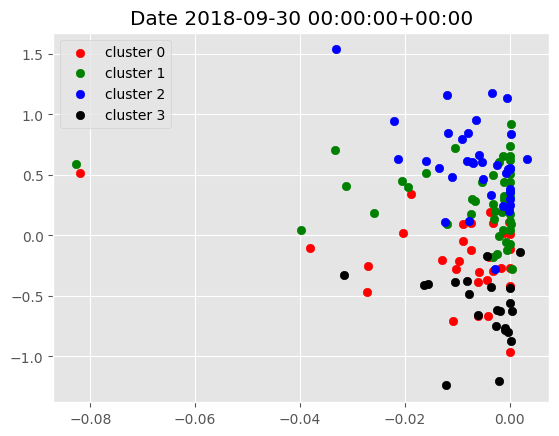

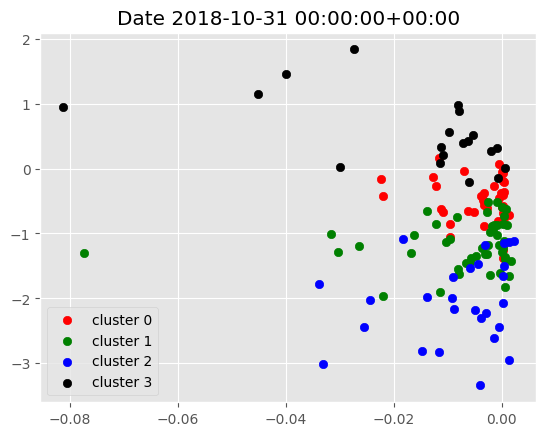

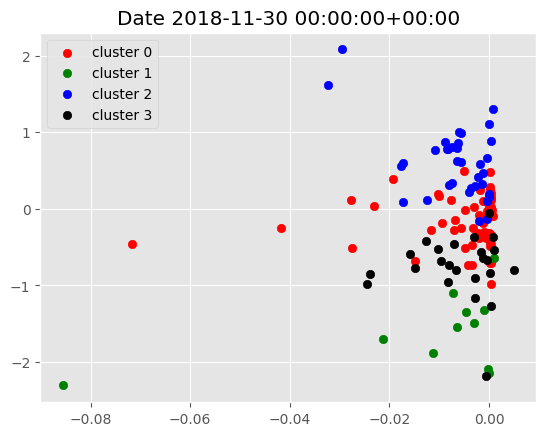

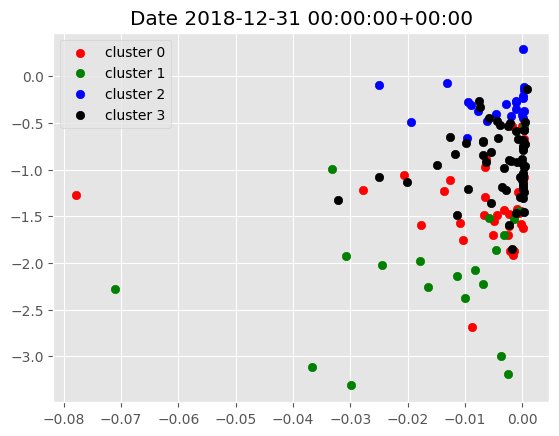

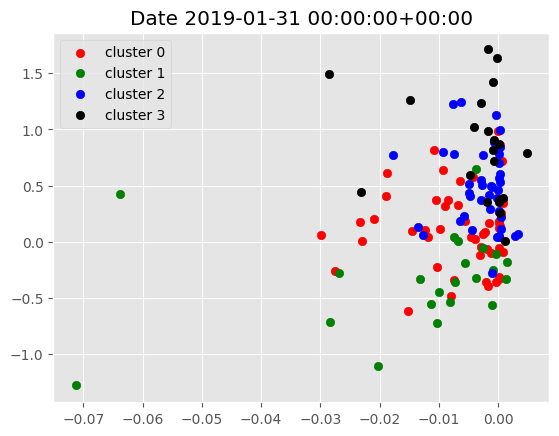

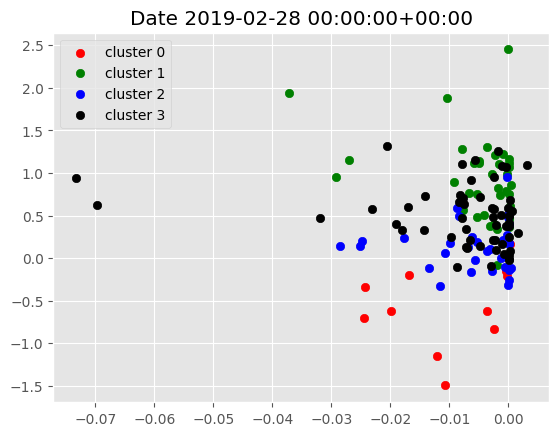

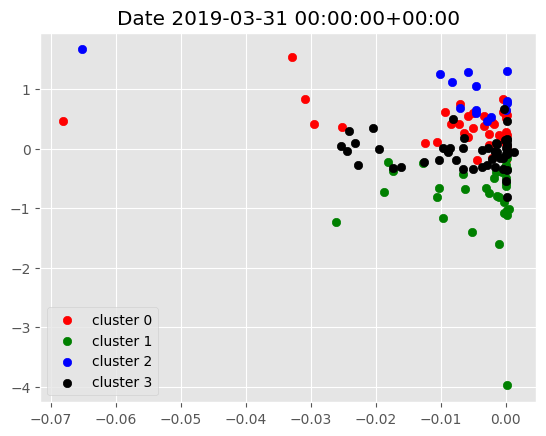

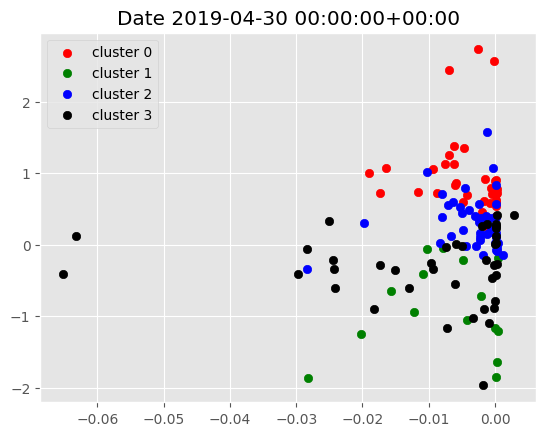

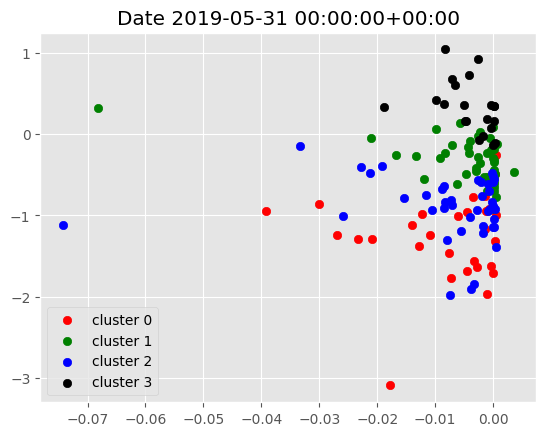

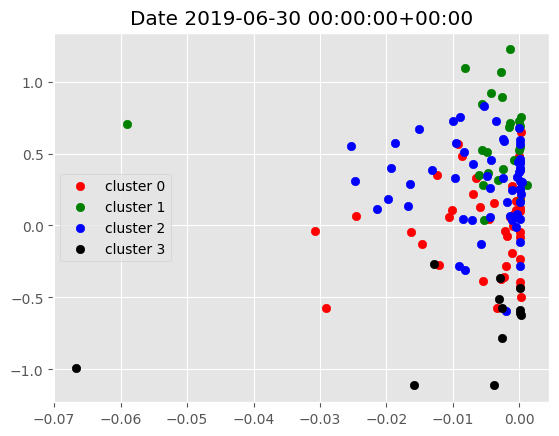

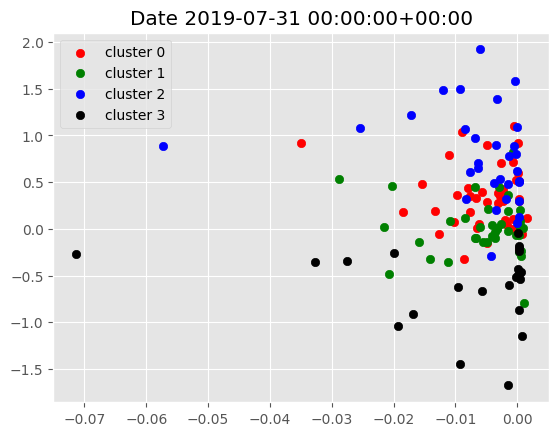

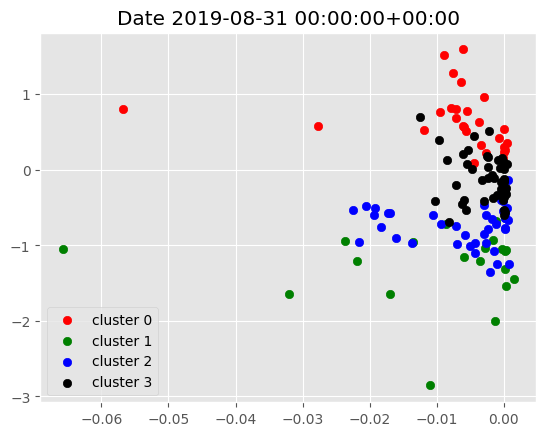

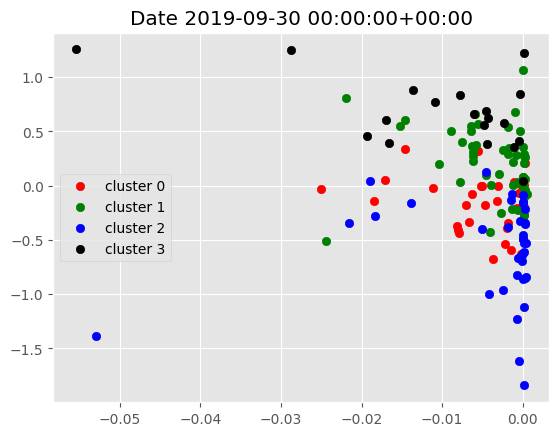

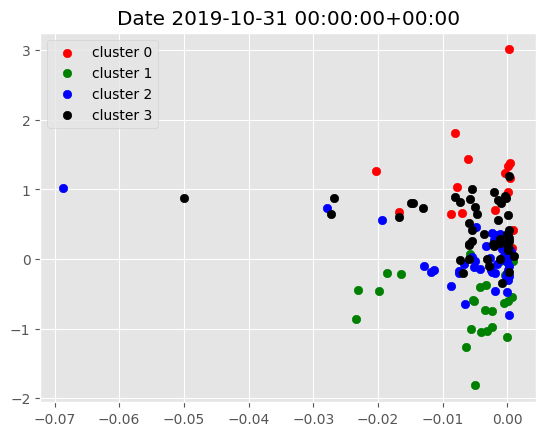

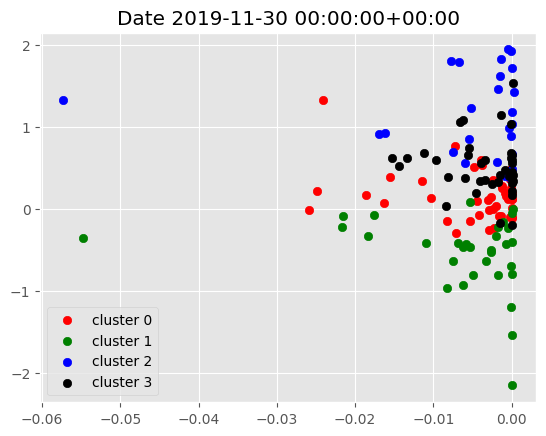

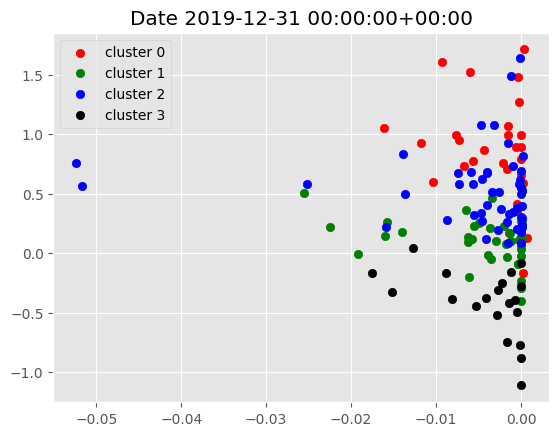

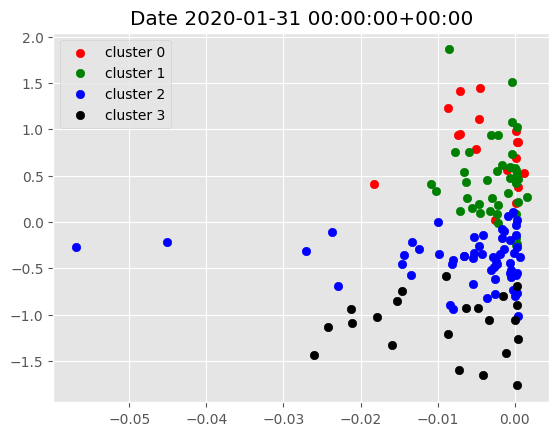

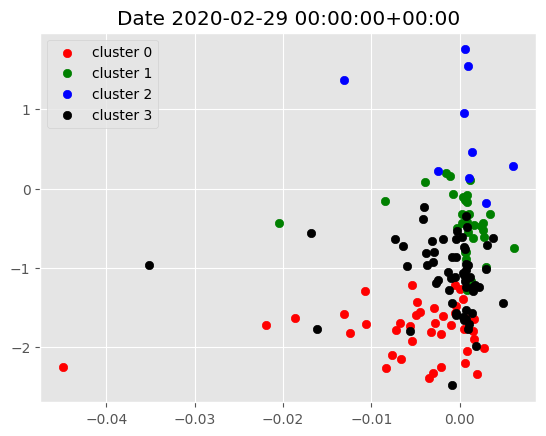

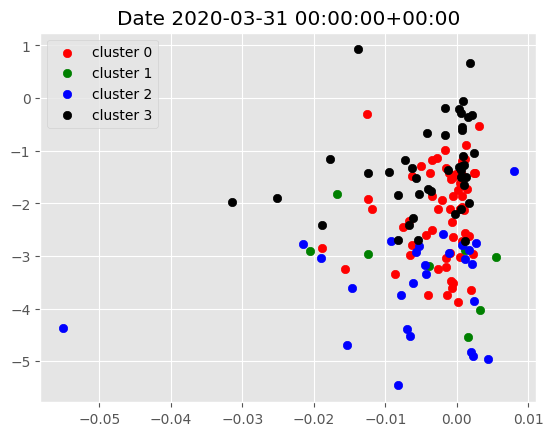

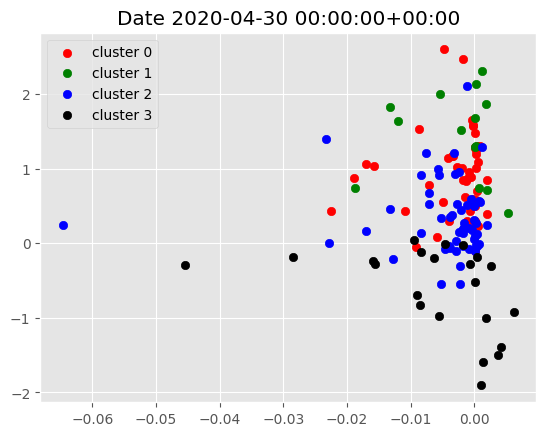

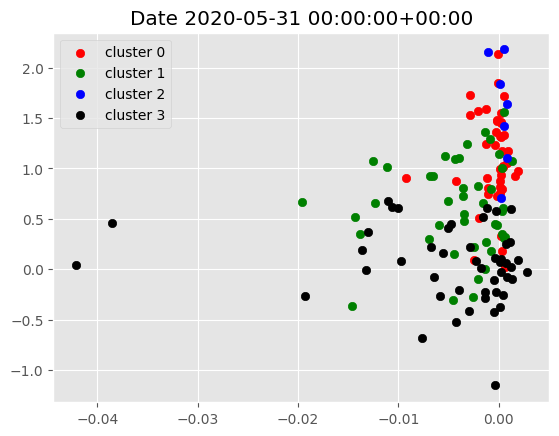

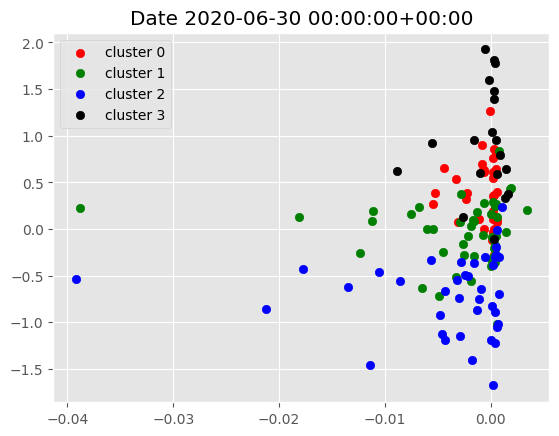

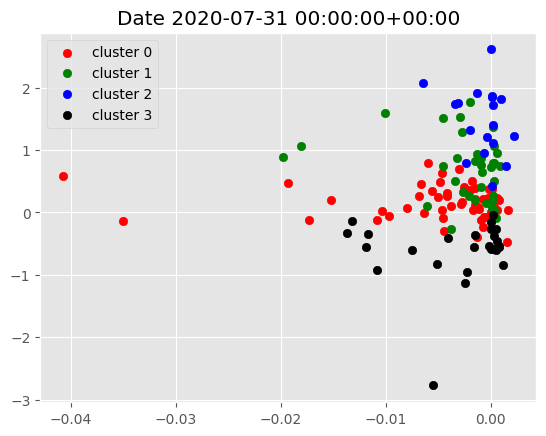

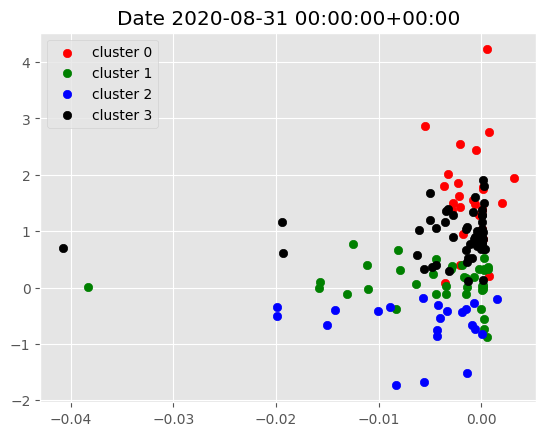

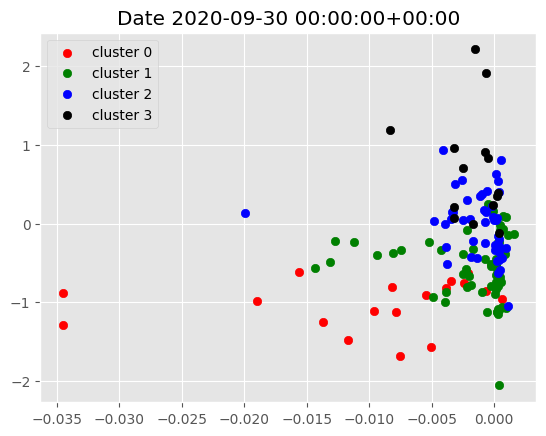

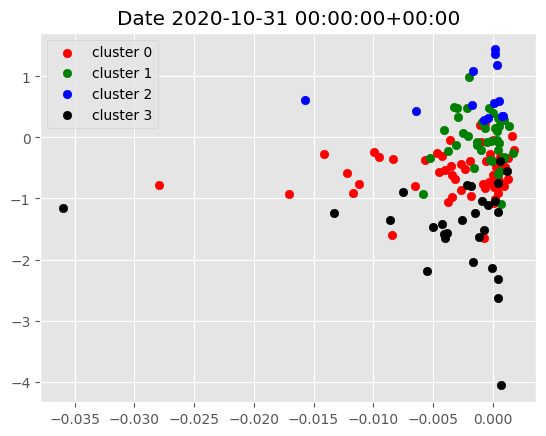

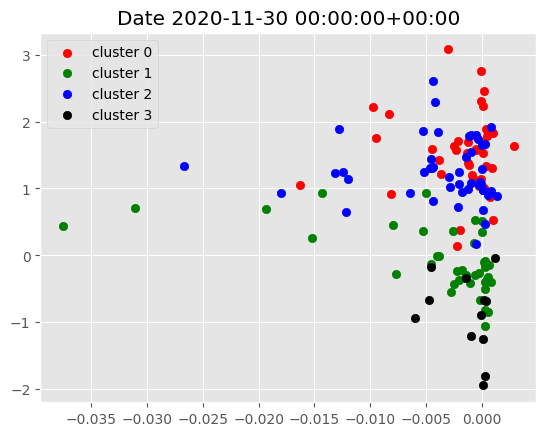

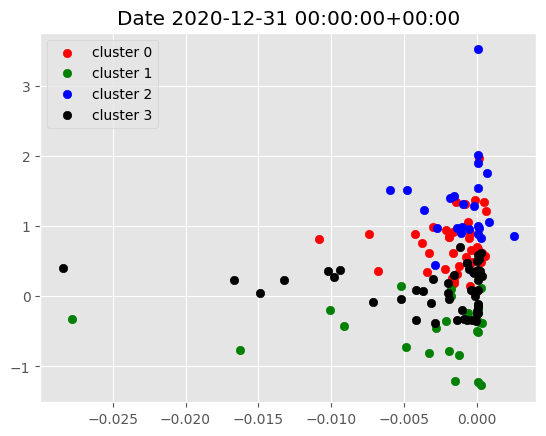

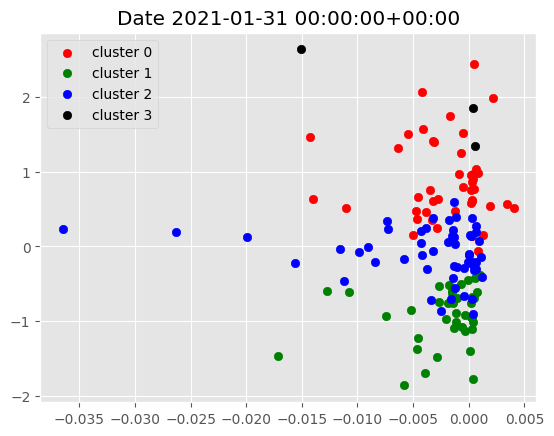

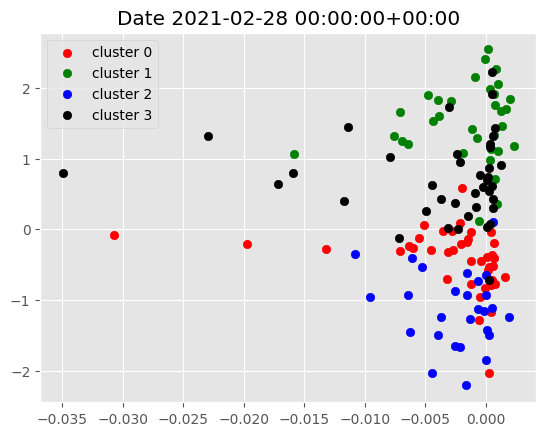

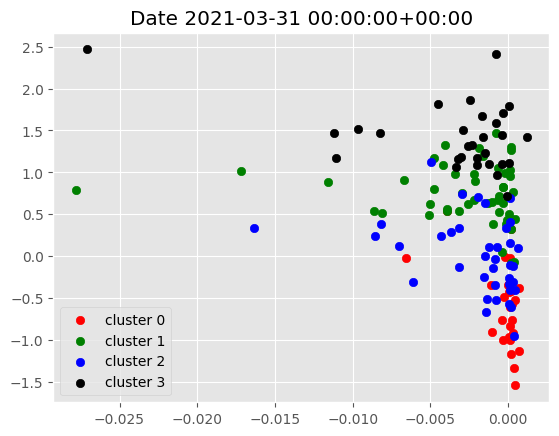

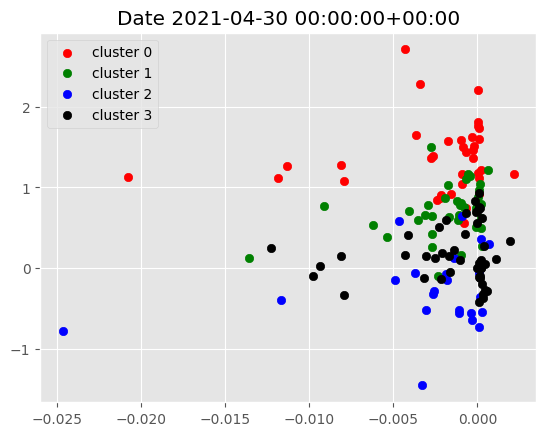

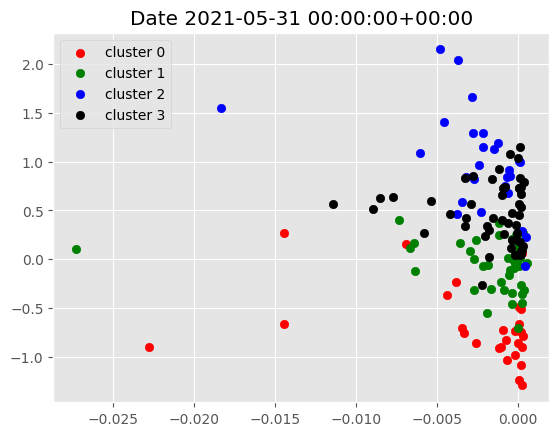

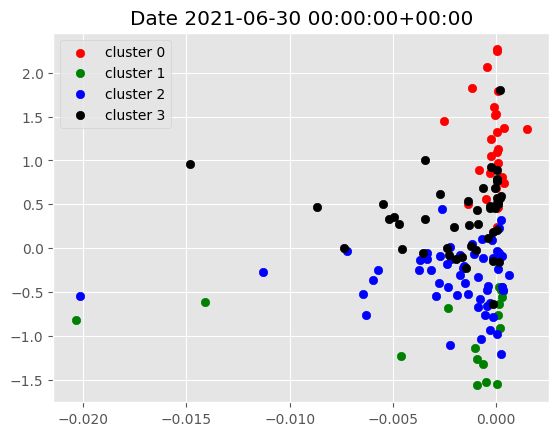

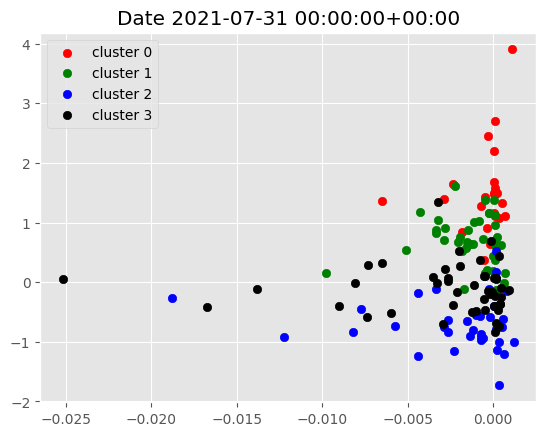

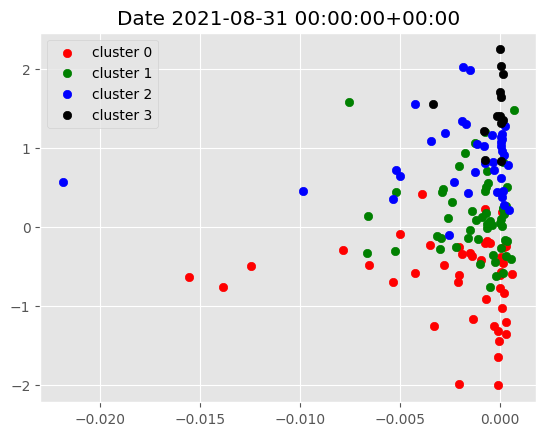

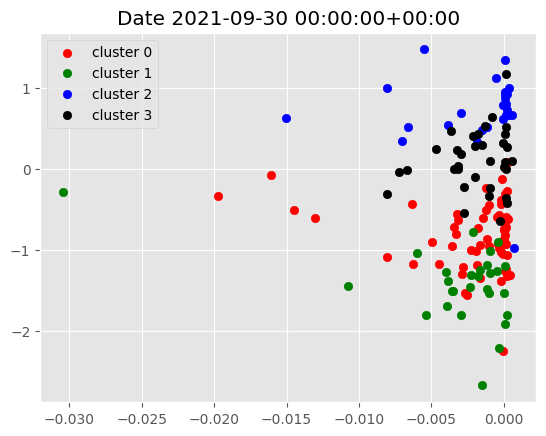

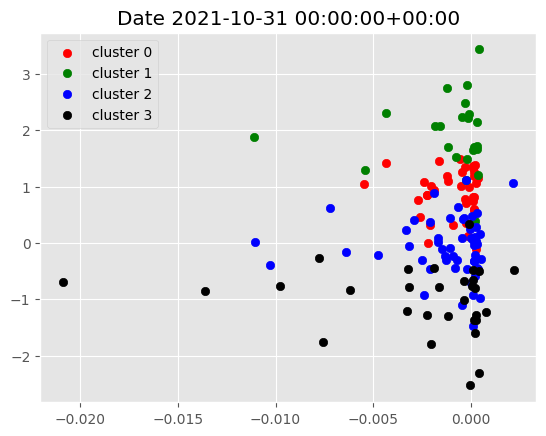

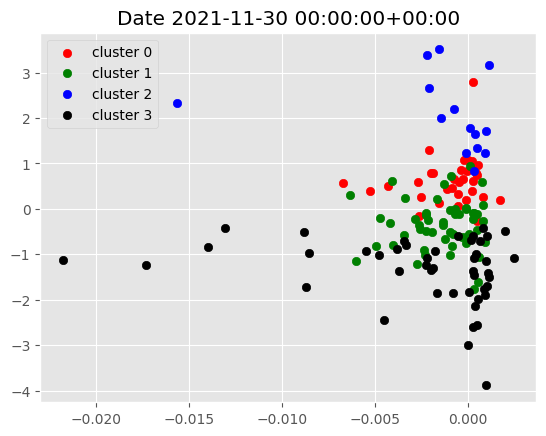

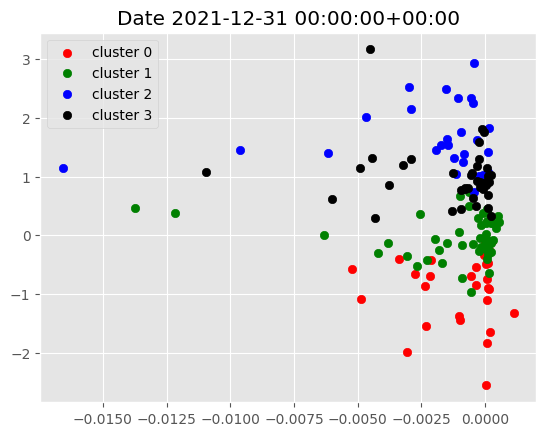

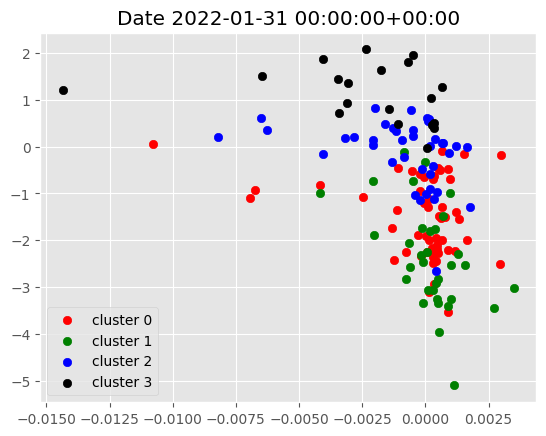

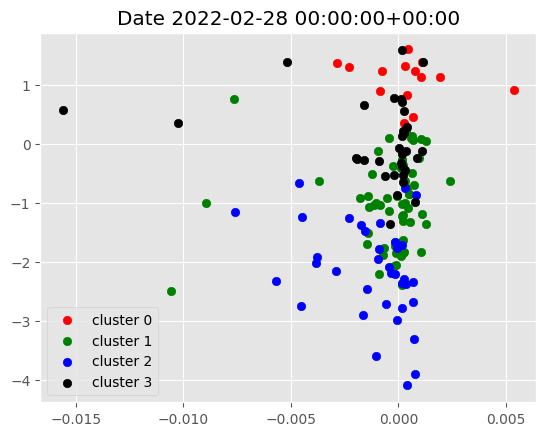

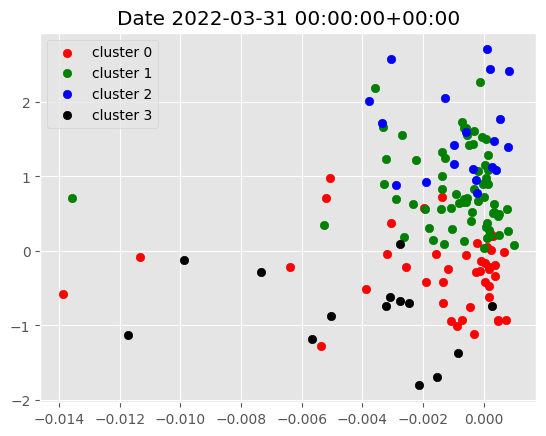

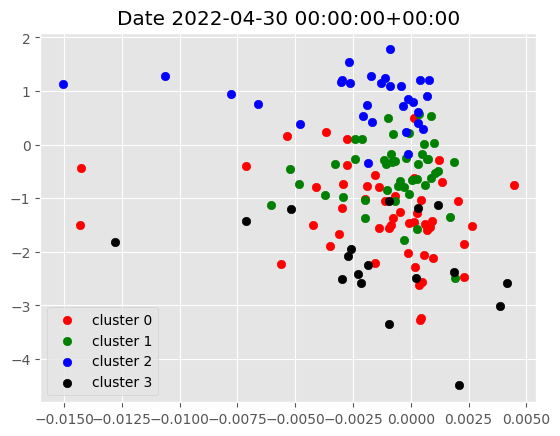

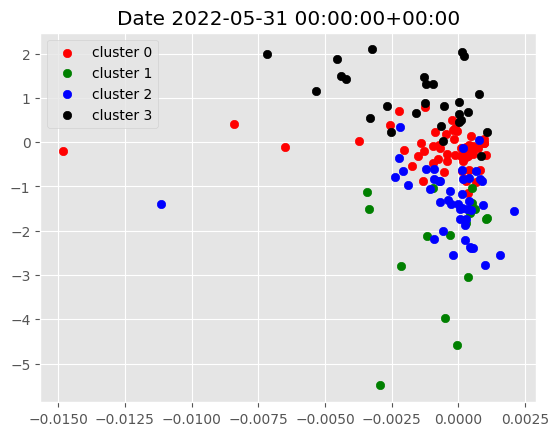

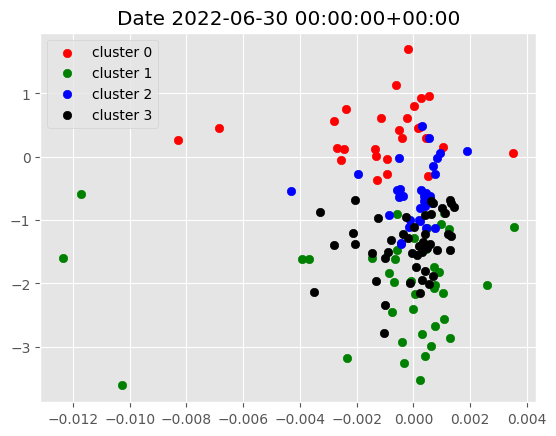

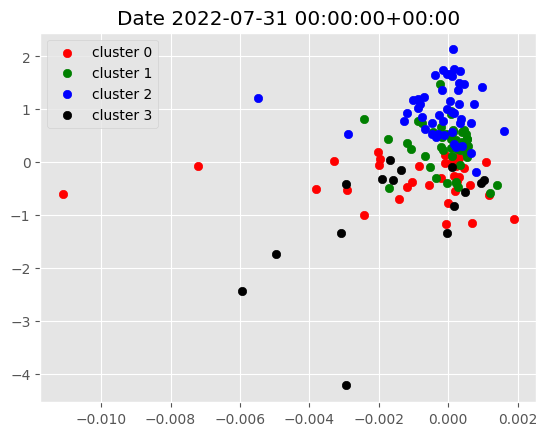

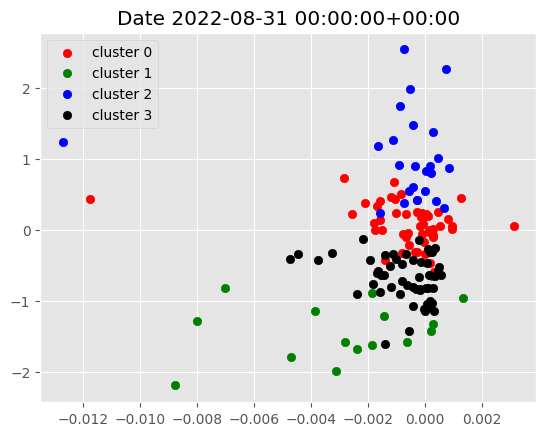

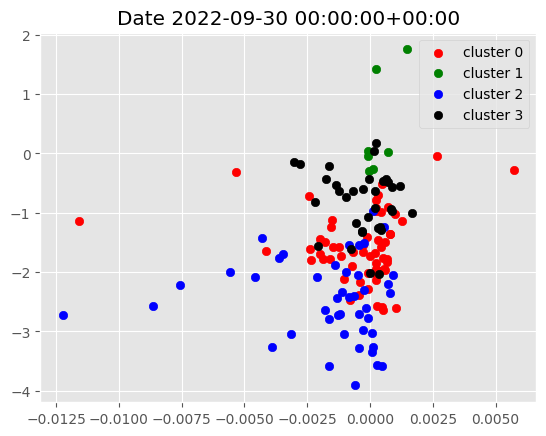

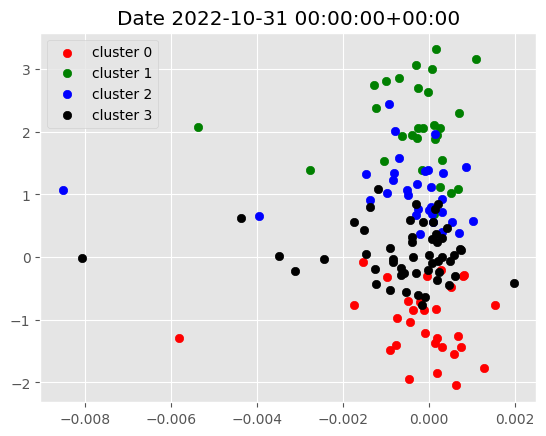

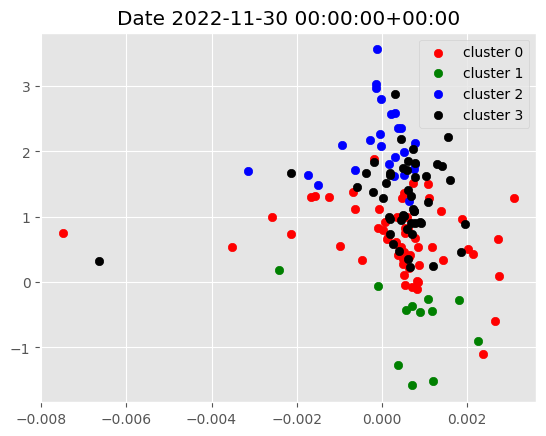

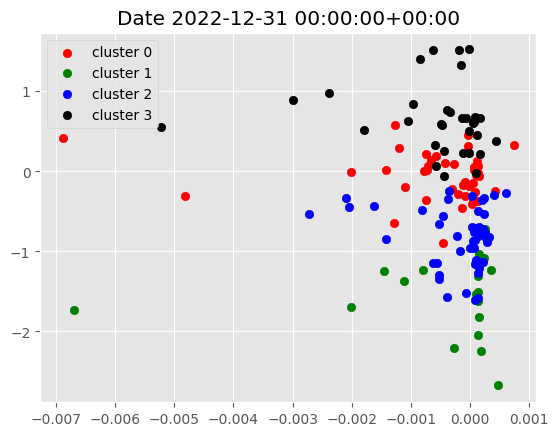

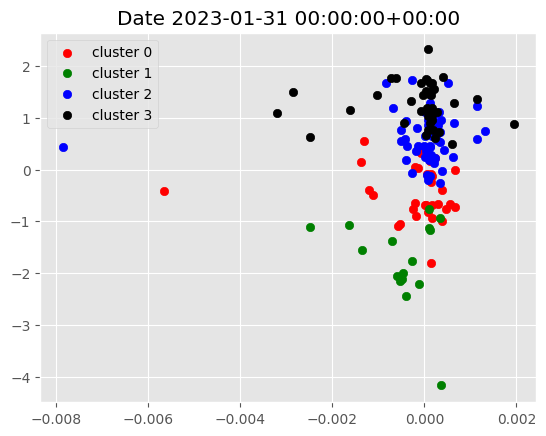

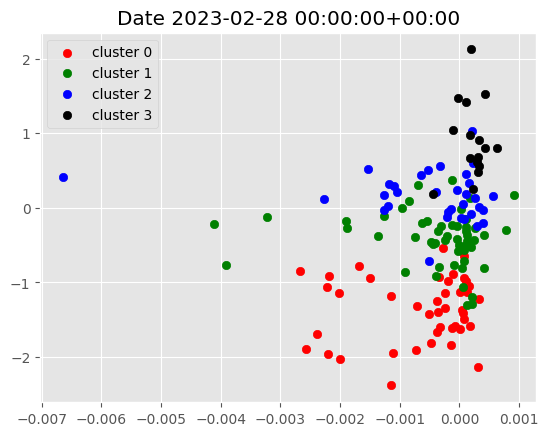

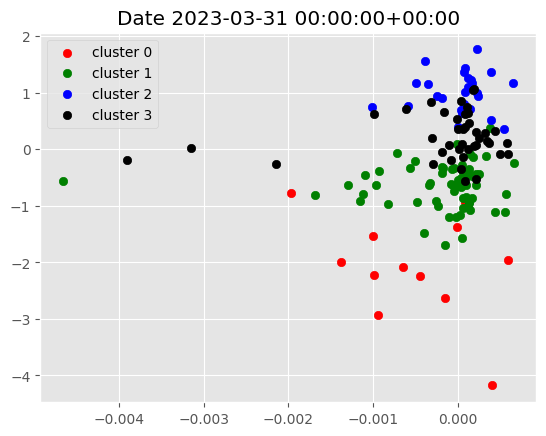

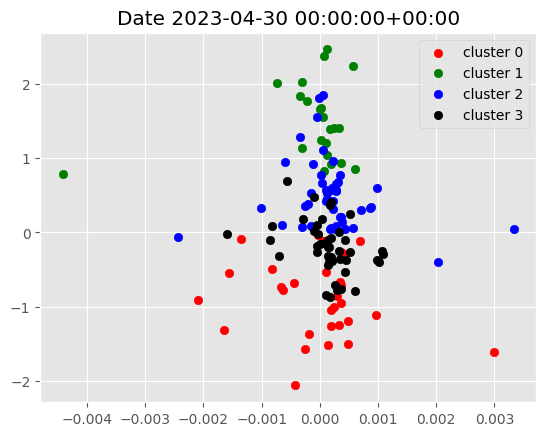

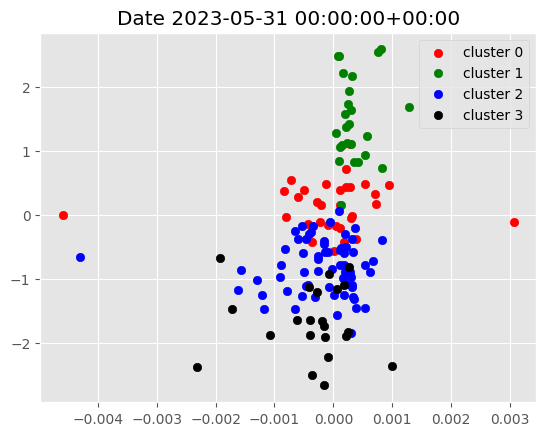

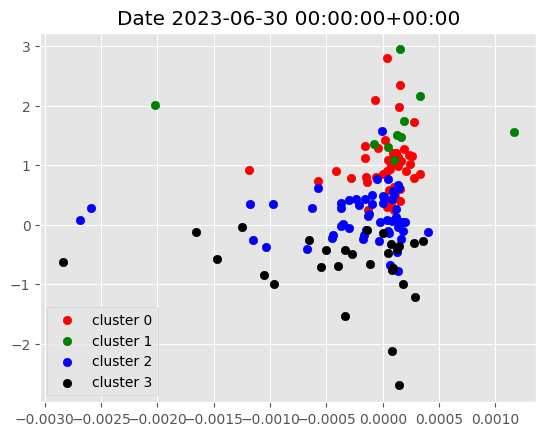

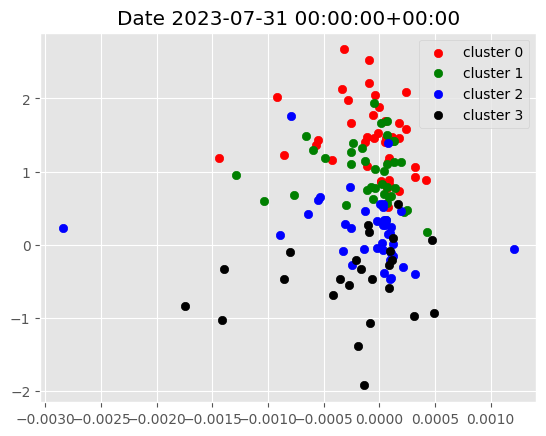

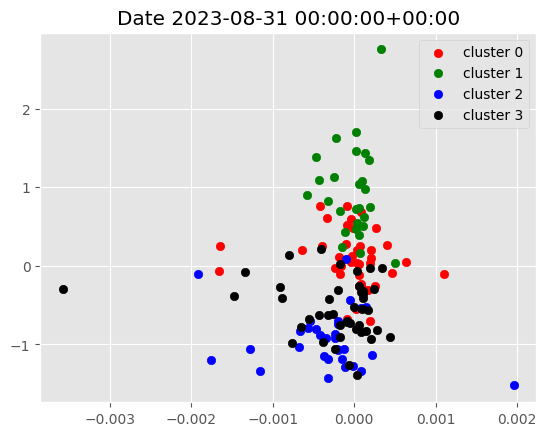

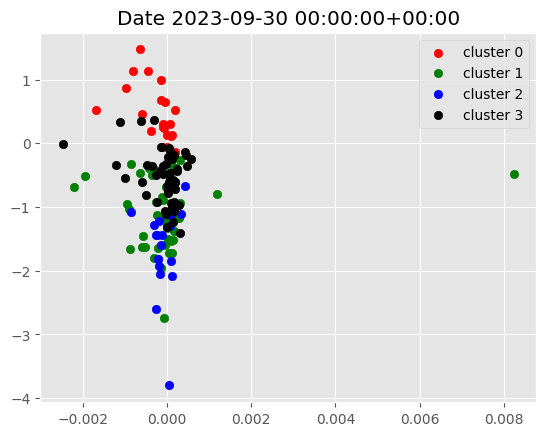

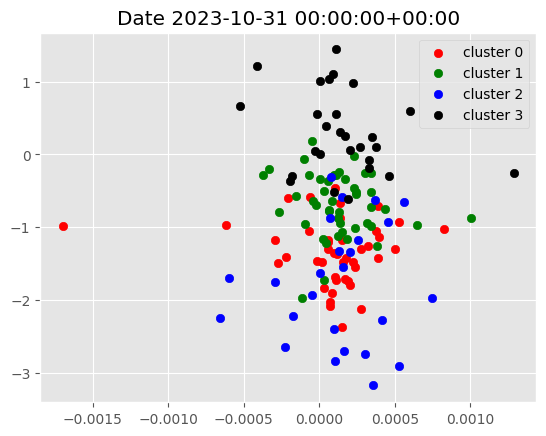

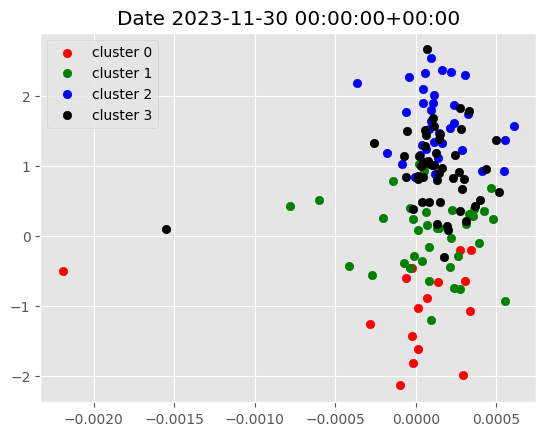

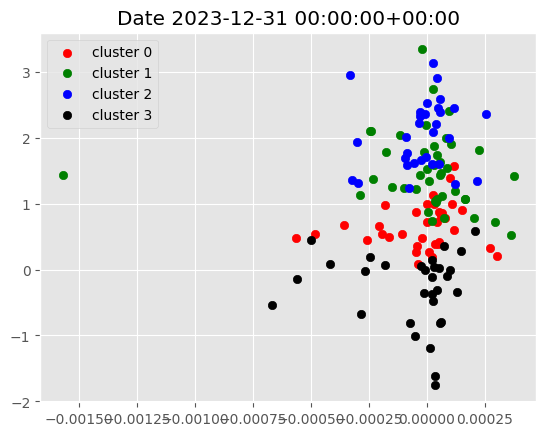

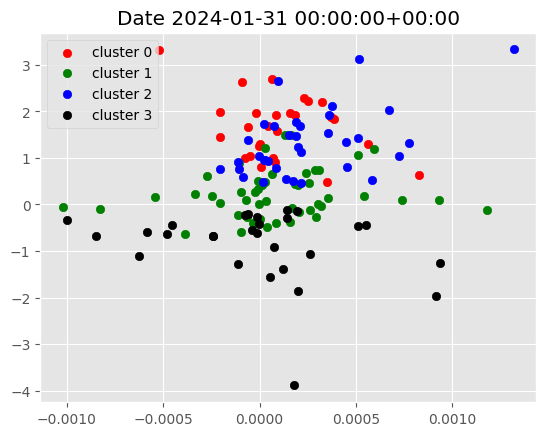

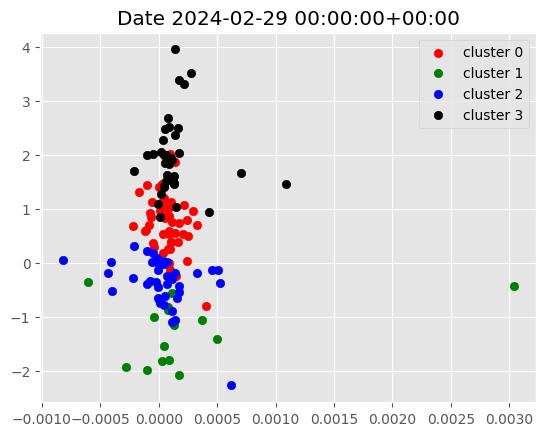

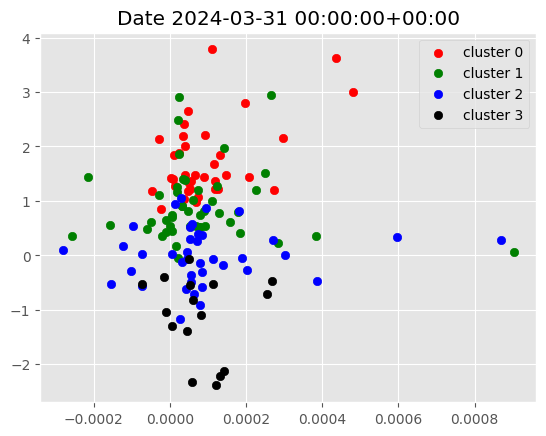

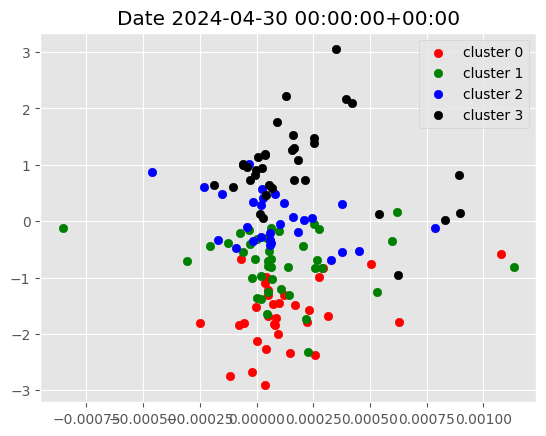

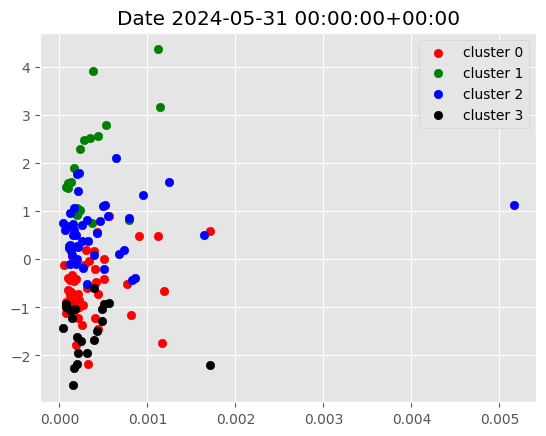

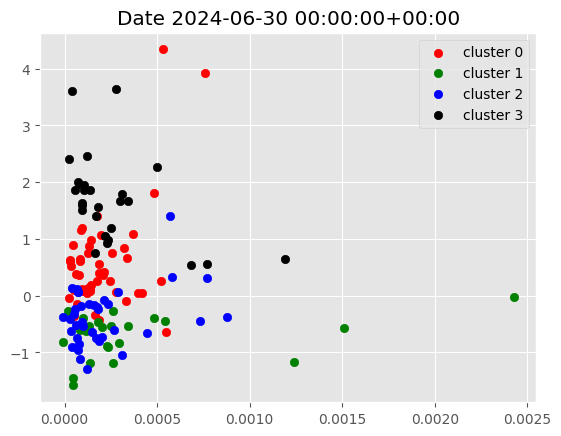

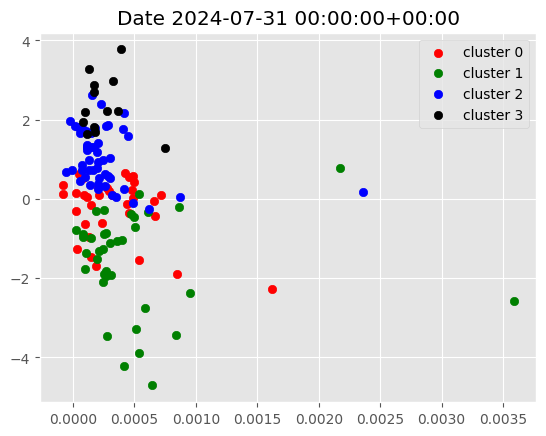

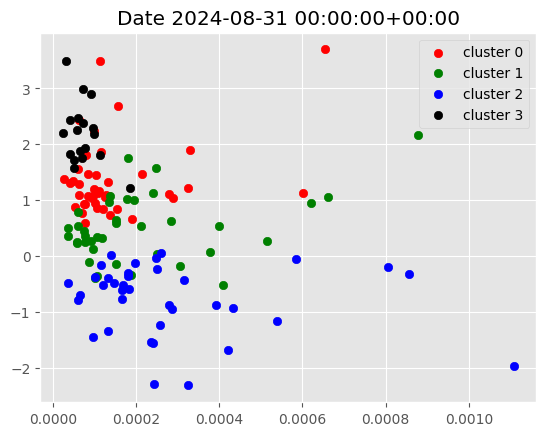

In [298]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)



In [299]:
#Apply pre-defined centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [300]:
#for each month, select stocks based on our clustering and form a portfolio
#Based on Efficient Frontier max sharpe ratio optimization
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-10-01': ['AMAT',
  'BAC',
  'CMG',
  'DD',
  'DLTR',
  'EBAY',
  'F',
  'GE',
  'GM',
  'GS',
  'LRCX',
  'META',
  'MS',
  'MU',
  'NXPI',
  'SCHW',
  'SLB',
  'TSLA',
  'UPS',
  'WDC',
  'WFC',
  'WYNN'],
 '2018-11-01': ['AMT',
  'CI',
  'CMCSA',
  'DG',
  'F',
  'GM',
  'JNJ',
  'KO',
  'KR',
  'MCD',
  'MO',
  'MRK',
  'PG',
  'PM',
  'SBUX',
  'TSLA',
  'VZ',
  'WBA',
  'WMT'],
 '2018-12-01': ['AIG',
  'AMD',
  'BMY',
  'C',
  'COP',
  'DD',
  'EOG',
  'IBM',
  'LMT',
  'LOW',
  'MAR',
  'MCK',
  'META',
  'MS',
  'MU',
  'NFLX',
  'OXY',
  'PANW',
  'QCOM',
  'RTX',
  'SCHW',
  'STZ',
  'TJX',
  'WDC'],
 '2019-01-01': ['AAL',
  'ADBE',
  'ADI',
  'ADSK',
  'AIG',
  'AMAT',
  'AMD',
  'AMT',
  'AMZN',
  'BA',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'CMG',
  'COP',
  'CSCO',
  'CVX',
  'DD',
  'DIS',
  'EBAY',
  'ELV',
  'GE',
  'GM',
  'GOOG',
  'GOOGL',
  'HD',
  'ISRG',
  'KO',
  'LOW',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MDT',
  'MGM',
  'MMM',
  '

In [301]:
#Define the portfolio optimization function
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [302]:
#download fressh daily prices only for short listed stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  154 of 154 completed


Price                      Adj Close                                      \
Ticker                           AAL        AAPL        ABBV         ABT   
Date                                                                       
2017-10-02 00:00:00+00:00  46.419174   36.094028   66.516510   47.515816   
2017-10-03 00:00:00+00:00  49.122822   36.251236   66.008759   47.577770   
2017-10-04 00:00:00+00:00  49.336781   36.016582   66.155907   48.100010   
2017-10-05 00:00:00+00:00  49.171455   36.464798   66.361977   48.613422   
2017-10-06 00:00:00+00:00  49.891129   36.443672   66.590088   48.684227   
...                              ...         ...         ...         ...   
2024-08-23 00:00:00+00:00  10.390000  226.839996  197.550003  112.690002   
2024-08-26 00:00:00+00:00  10.210000  227.179993  197.440002  112.699997   
2024-08-27 00:00:00+00:00  10.170000  228.029999  195.919998  113.099998   
2024-08-28 00:00:00+00:00  10.150000  226.490005  195.399994  112.900002   
2024-08-29 00:00:00+00:00  10.435100  230.330002  195.229996  112.730003   

Price                                                                      \
Ticker                            ACN        ADBE         ADI         ADP   
Date                                                                        
2017-10-02 00:00:00+00:00  121.396393  147.940002   75.437134   94.806877   
2017-10-03 00:00:00+00:00  120.329781  148.600006   75.507431   96.012367   
2017-10-04 00:00:00+00:00  121.145439  147.949997   76.474365   96.610756   
2017-10-05 00:00:00+00:00  122.095520  150.250000   77.256668   98.492668   
2017-10-06 00:00:00+00:00  122.122398  151.119995   77.239105   98.414619   
...                               ...         ...         ...         ...   
2024-08-23 00:00:00+00:00  333.269989  558.299988  228.389999  269.600006   
2024-08-26 00:00:00+00:00  336.779999  559.440002  225.610001  271.350006   
2024-08-27 00:00:00+00:00  340.380005  567.820007  231.839996  274.679993   
2024-08-28 00:00:00+00:00  337.390015  560.539978  227.169998  272.679993   
2024-08-29 00:00:00+00:00  340.760010  570.299988  231.610001  273.516388   

Price                                             ...   Volume           \
Ticker                           ADSK        AIG  ...        V      VLO   
Date                                              ...                     
2017-10-02 00:00:00+00:00  112.470001  51.633629  ...  4885600  3141300   
2017-10-03 00:00:00+00:00  113.629997  51.441654  ...  4411100  3194700   
2017-10-04 00:00:00+00:00  114.050003  51.399929  ...  4146800  2669900   
2017-10-05 00:00:00+00:00  116.540001  51.733788  ...  4396100  4923400   
2017-10-06 00:00:00+00:00  116.959999  51.967503  ...  4587000  4672400   
...                               ...        ...  ...      ...      ...   
2024-08-23 00:00:00+00:00  255.259995  75.320000  ...  3697400  1524000   
2024-08-26 00:00:00+00:00  256.209991  74.610001  ...  4612200  2752200   
2024-08-27 00:00:00+00:00  256.989990  74.430000  ...  6594100  2030300   
2024-08-28 00:00:00+00:00  254.619995  75.519997  ...  5454800  2139700   
2024-08-29 00:00:00+00:00  258.829987  76.080002  ...  2957582  1042300   

Price                                                                      \
Ticker                        VRTX        VZ       WBA      WDC       WFC   
Date                                                                        
2017-10-02 00:00:00+00:00  2057700   9525800   5513900  7502300  11764400   
2017-10-03 00:00:00+00:00   995000  10218600   4934300  4576500  17405100   
2017-10-04 00:00:00+00:00   970200   9887500   4652600  3414300  14697800   
2017-10-05 00:00:00+00:00  1273700  12230600   4622700  5481400  14560700   
2017-10-06 00:00:00+00:00  1551100  13239600  11629900  3489900  11151200   
...                            ...       ...       ...      ...       ...   
2024-08-23 00:00:00+00:00   999700  11757300  18159300  3045400  17074400   
2024-08-26 00:00:00+00:00   877600 

In [316]:
#Calculate daily returns for stocks which could end up in our port
#Loop over each month, select stocks, calculate weights for the next month
#if max sharpr ratio optimization fails, apply equally-weighted weights

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df





'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'
'Adj Close'


""


In [304]:
#Compare Port returns  to SP500
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,SPY Buy&Hold


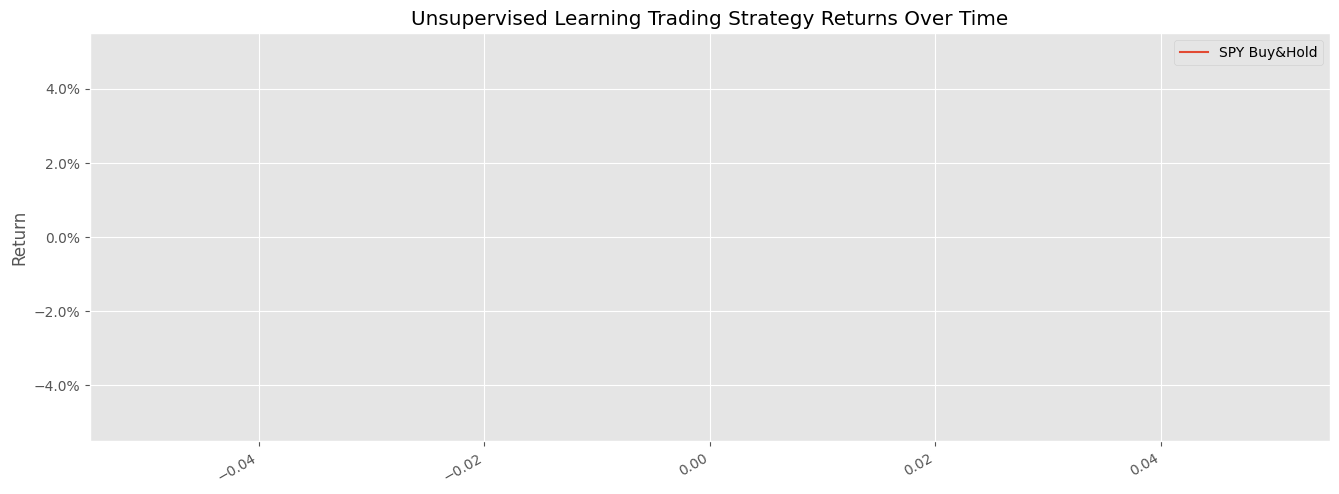

Empty DataFrame
Columns: [SPY Buy&Hold]
Index: []
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [313]:
#Visualize my returns to spy500
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

# Ensure 'portfolio_df' has data up to the current date
today = pd.Timestamp.now().strftime('%Y-%m-%d')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1

# Slice up to today
portfolio_cumulative_return[:today].plot(figsize=(16, 6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

print(portfolio_cumulative_return.head())
print(portfolio_cumulative_return.index)
